# Neural networks

In the previous lecture, we learned about conventional machine learning approaches for regression and classification. We found that such models have useful analytical and computational properties but that their practical applicability to common tasks in Earth Science was limited. These tasks require models that can automatically recognize complex patterns in our data. For our image classification, this might be the shape or texture of meltwater ponds on the ice sheet. For our time-series prediction, this might be changing sensitivity of discharge to air temperature during different times of the year (e.g. caused by snowpack dynamics). 

More powerful approaches for statistical pattern recognition are provided by a class of models called **neural networks**. The term "neural network" has its origins in attempts to find mathematical representations of information processing in biological systems. Neural networks have multiple hidden layers which allows them learn increasingly abstract representations in our data. We therefore refer to this type of machine learning as **deep learning**. 

The quintessential model of this type is known as a **feed-forward neural network** (or multilayer perceptron). These models are called **feed-forward** because information flows from the input layer, through hidden layers, to the output layer without looping back. When feed-forward neural networks are extended to include **feedback connections**, they can recognize sequences in data (e.g. temporal dependencies). These type of models are called **recurrent neural networks** (RNNs). Likewise, when **convolutional layers** are added to feed-forward neural networks, they can start to learn spatial dependencies in our data (e.g. shape and texture of image). We call these models **convolutional neural networks** (CNNs). 

In this lecture, we will develop an understanding of neural networks and demonstrate how they can be applied to improve performance on our image classification and time-series prediction tasks.

## Example - Nisqually River discharge

As always, we will use an example to demonstrate key concepts.

```{image} images/nisqually.png
:width: 600px
:align: center
```

Just like before, we will read our training dataset which contains climate data as features and discharge as the target variable.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Set seed value
tf.random.set_seed(0)

# Read data
df = pd.read_csv('data/nisqually.csv', parse_dates=['Date'], index_col=['Date'])

# Define feature list
feature_list =  df.columns.to_list()[:-1]
X = df[feature_list]
y = df['Nisqually Discharge']

Nex we will standarize our features and define the task which is to train our model on 8 years of discharge between 2013 and 2020 so that it can predict a whole year of discharge for 2021 from just climate data. Note that it is safer to also scale our target variable when training a deep learning model. 

In [128]:
# Standarize features
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.index = X.index

# Define start and end
start = '2021-01-01'
end = '2021-12-31'

# Split data 
X_train = X_scaled[:start]
X_test = X_scaled[start:end]
y_train = y[:start]
y_test = y[start:end]

# Scale target
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1))

## `TensorFlow`

Now we will define a relatively simple **multilayer perceptron** (or feed-forward neural network). To do this, we will use `TensorFlow`, an open-source deep learning package developed by Google. `TensorFlow` provides the tools for building and training neural networks and is widely used in academia and industry. The name is derived from two core ideas: a **tensor** which is basically array of numbers (which may be higher dimensional than a vector or a matrix, which are 1D and 2D tensors) and **flow** which describes the movement of the tensors through some sort of computational network (e.g multiply, convolution, activation). 

In [159]:
from tensorflow.keras import layers, models, optimizers

# Define shape of training data
input_dim = X_train.shape[1]

# Define neural network architecture
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'), 
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

This model has three main components:

* An input layer which takes a vector of size `input_dim`, representing the number of features in our climate data.

* Three hidden layers, each of which has 32 **nodes** which represent numbers (between 0 and 1). Initially, the numbers that the nodes represent are random but during training they are updated using a **ReLU (Rectified Linear Unit)** activation function.

* An output layer that produces a continuous value representing scaled discharge.

## A single node

```{image} images/node.png
:width: 500px
:align: center
```

Neural networks consist of nodes that receive input from other nodes and computes an output. In this model, we have 106 nodes (9 + 32 + 32 + 32 + 1). 

The output from each node depends on the **weighted sum** of the inputs and some **bias** so that this weighted sum has to cross some threshold before the node is activated. 

We then use an **activation function** to **non-linearly** convert this weighted sum (+ bias). In the model, we use a **ReLU** activation function (`activation='relu'`) which converts all negative values to zero but there are others such as a **sigmoid** that convert values to between 0 and 1, and **tanh** that converts values to between -1 and 1.

$$
a = \text{ReLU}\!\left(w_0 x_0 + w_1 x_1 + w_2 x_2 + b\right)
$$

## Activation functions

```{image} images/functions.png
:width: 600px
:align: center
```

## Architecture

Our neural network is **fully connected** meaning that our nodes are organized in layers such that **every node in one layer is connected to every node in the adjacent layer**. Hence the term **multilayer** perceptron which defines a feedforward neural network with one or more hidden layers. 

```{image} images/network.png
:width: 500px
:align: center
```

In [161]:
# Show model summary
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_104 (Dense)               │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,465 (9.63 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 0 (0.00 B)

## Parameters

The number of parameters in our neural network therefore depends on the number of nodes and layers. In our model that we defined above we have **2,465 trainable parameters**. 

* 320 between our input layer and first hidden layer (9 x 32) + 32

* 1056 between our first and second hidden layers (32 x 32) + 32

* 1056 between our second and third hidden layers (32 x 32) + 32

* 33 between our third hidden layer and output layer (32 x 1) + 1

```{note}
ChatGPT-4 is estimated to have roughly 1.8 trillion parameters.
```

## Network training

We now need an algorithm to update these weights and biases so that our model can predict discharge accurately. We use several different types of algorithm to do this. 

### Cost function

The first is called a **cost function**. In supervised learning, we can compare the outputs training samples (initially produced using a neural network with random weights and biases) with their actual discharge values. The difference, usually computed as the **mean-squared-error (MSE)**, provides the model with error (also known as **loss**) that the model will attempt to minimize.

### Optimization

Now we need some method to reduce the loss by updating the weights in the network. We could randomly adjust the weights and see what happens. But a more efficient way is to use an **optimization algorithm** which computes the derivative of the loss with respect to the network weights. This is known as **gradient descent**. 

```{image} images/gradient-descent.png
:width: 500px
:align: center
```

A key parameter for gradient descent is the **learning rate** which controls the step size during optimization. A learning rate that is:

* Too high will cause the model to bounce around without converging

* Too low will cause the model to converge very slowly and may get stuck at local minima

Unfortunately, computing the gradients for every training sample, for every node in our network would take a long time. So we usually estimate the gradient by computing the derivative of the loss on random samples of our training dataset. This is called **stochastic gradient descent**. 

```{warning}
If gradient becomes zero (e.g. saddle point, or local minima), then this optimization approach gets stuck. 
```

```{image} images/local-min.png
:width: 500px
:align: center
```

A velocity term (weighted average of previous gradients) is usually added to stochastic gradient descent (i.e. **SGD + momentum**) which enables the algorithm to overcome zero gradients and escape shallow local minima. Other approaches to improve gradient descent include **RMSProp**, **Adam** (Adaptive Moment Estimation), and **AdamW** (Adam + weight decay).

### Backprop

The final algorithm is called **backpropagation** which recursively applies the **chain rule** to compute gradients back through the network. Backpropagation substantially reduces the computational cost of computing gradients. It therefore enabled researchers to train **deep** neural networks that proved to be much more accurate than the shallow neural networks that were previously being used. 

Below we compile our model that we defined earlier.

In [164]:
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

model = build_model(input_dim)

## Fitting model

We are now ready to **`fit`** our model to the training data. The key parameters here are `batch_size` which determines how many samples we should use to compute the losses (i.e. MSE) and gradients before moving onto the next batch. An `epoch` is therefore one full pass through the training dataset (i.e. training on all batches). The number of training cycles (or iterations) is therefore defined as the number of batches multiplied by the number of epochs.  

Finally, we define a `validation_split` which is the proportion of the dataset to hold-out from training during each epoch. Data in the validation dataset will be used for training (during other epochs). But separating them out during training allows us to monitor how well the model is performing on unseen data **while it is training**. This can be useful when model takes multiple hours (or days) to fit. 

In [163]:
# Define batch size and epochs
batch_size = 128
epochs = 100

# Compute number of training cycles
print(X_train.shape[0] / batch_size * 100)

2283.59375


```{note}
Smaller batches are faster to backpropagate so this number is not directly proportional to training time.
```

In [141]:
history = model.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

## Evaluating model

We can evaluate our model against our test dataset using the Nash-Sutcliffe Efficiency (NSE) metric that we introduced earlier.  

In [145]:
# Predict on test set
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(1, -1))

# Compute Nash-Sutcliffe index
nse = 1 - np.sum((y_test - y_pred[0,:]) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"NSE: {nse:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
NSE: 0.61


We find a value that is similar to the 0.56 that we achieved with the Histogram Gradient Boosting (noting that higher value = better). Let's plot the predicted vs actual discharge for 2021. 

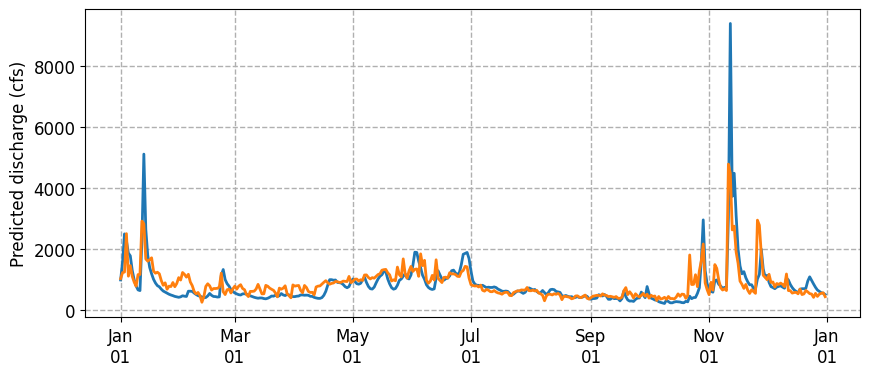

In [147]:
# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['2021-01-01':'2021-12-31'].index, df['Nisqually Discharge']['2021-01-01':'2021-12-31'], lw=2, zorder=3)
ax.plot(y_test.index, y_pred[0,:], lw=2, zorder=3)
ax.set_ylabel('Predicted discharge (cfs)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))

We can investigate the model accuracy in more detail by producing a **learning curve**.

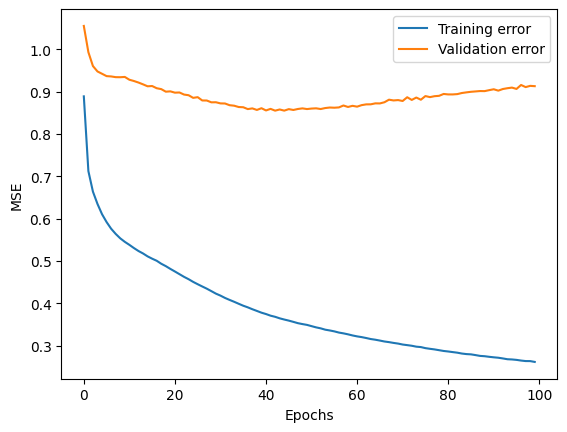

In [143]:
plt.plot(history.history['loss'], label='Training error')
plt.plot(history.history['val_loss'], label='Validation error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

We find that the validation error starts to increase after some number of epochs indicating that the model is **overfitting** because it is **memorizing** our dataset. This is perhaps not surprising given the flexibility (2,465 trainable parameters) of neural networks.

## Regularization

There are several **regularization** strategies we can deploy to prevent overfitting. Regularization is defined as:

> Any modification we make to the learning algorithm that is intended to reduce its generalization error but not it training error 


```{important}
It is recommended not to use the size of the network as a regularizer. Instead, we almost always find that the best fitting model is a large model that has been regularized appropriately. 
```

The first strategy we can use is **early stopping** which simply stops training when validation loss stops improving. During training, we store a copy of the model parameters. When the algorithm terminates, we return the parameters with the lowest validation error, rather than the latest parameters. This is one of the most commonly used regularization strategies in machine learning because of its effectiveness and simplicity. 

`TensorFlow` makes this easy to implement. We just need to specify a `patience` parameter that defines the number of epochs with no improvement after which training will be stopped.

In [144]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build model
model = build_model(input_dim)

# Fit model
history = model.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=epochs,
    batch_size=epochs,
    callbacks=[early_stop],
    verbose=0
)

# Predict on test set
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(1, -1))

# Compute Nash-Sutcliffe index
nse = 1 - np.sum((y_test - y_pred[0,:]) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"NSE: {nse:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NSE: 0.61


We obtained a slight improvement using early stopping. Other regularization strategies include:

* **L2 regularization** (or weight decay) adds a penalty to the error function that encourages smaller weights when modifying gradients

* **Dropout** randomly “turns off” a fraction of nodes during training which prevents nodes relying too much on each other.

```{note}
Dropout is a deep learning approximation of **bagging**
```

We can implement these strategies as follows.

In [149]:
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        layers.Dense(1)
    ])
    model.compile(optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

model = build_model(input_dim)

history = model.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=0
)

# Predict on test set
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(1, -1))

# Compute Nash-Sutcliffe index
nse = 1 - np.sum((y_test - y_pred[0,:]) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"NSE: {nse:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NSE: 0.53


In [157]:
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])
    model.compile(optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

model = build_model(input_dim)

history = model.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=0
)

# Predict on test set
y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(1, -1))

# Compute Nash-Sutcliffe index
nse = 1 - np.sum((y_test - y_pred[0,:]) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
print(f"NSE: {nse:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NSE: 0.49


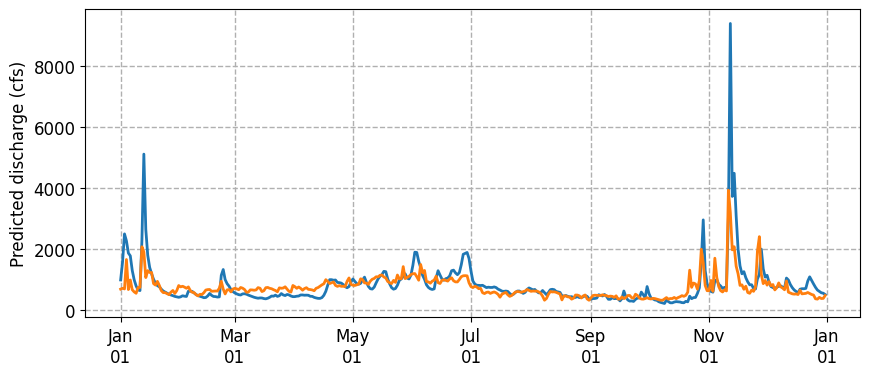

In [158]:
# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['2021-01-01':'2021-12-31'].index, df['Nisqually Discharge']['2021-01-01':'2021-12-31'], lw=2, zorder=3)
ax.plot(y_test.index, y_pred[0,:], lw=2, zorder=3)
ax.set_ylabel('Predicted discharge (cfs)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))

In practice, it is challenging to know which strategy (or combination of strategies) to use when developing a neural network that can generalize well. Furthermore, all strategies have parameters that can be tuned. We could also go back to start and define a neural network with more or less parameters. 

One approach to overcome this uncertainty is to use **hyperparameter tuning**. We can use this technique to get a sense of how different models setups, tuning parameters, and regularization strategies impact our testing error. 

## Further reading

Bishop, C. M. (2006). [Pattern recognition and machine learning](https://link.springer.com/9780387310732)

Goodfellow, I., Bengio, Y., & Courville, A. (2017) [Deep learning](https://www.deeplearningbook.org/)

Karn, U. (2016). [A Quick Introduction to Neural Networks](https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/)

Nielsen, M. A. (2015). [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/index.html)

Sanderson, G. (2018). [Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

Stanford CS class CS231n. [Deep Learning for Computer Vision](https://cs231n.github.io/)